In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(tf.Session(config=config))
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.
/home/user/Desktop/object-tracking-master/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


In [2]:
# Set the image size.
img_height = 512
img_width = 512


# load ssd pretrained model

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd_512'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'L2Normalization': L2Normalization,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

# read the video stream

In [21]:
from skvideo.io import vreader,vwrite
import matplotlib.pyplot as plt
import cv2
vr = vreader("traffic videos/Bangalore has a major traffic problem_ Busy roads of Karnataka.mp4")
input_images=[]
orig_images = []
i=0
for v in vr:
    orig_images.append(v)
    v=cv2.resize(v,(img_height,img_width))
    input_images.append(v)
    if(i>2000):
        break
    i=i+1
input_images = np.array(input_images)
print(input_images.shape) 

(2002, 512, 512, 3)


# predict

In [5]:
y_pred = model.predict(input_images,batch_size=1)
print(y_pred.shape)

(2002, 500, 6)


# 

In [6]:
confidence_threshold = 0.2

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[30])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  6.     0.87 182.95 168.09 262.51 293.91]
 [  6.     0.86  -2.61 190.39 212.68 497.91]
 [  6.     0.82 367.12 186.34 477.92 513.16]
 [  7.     0.72 187.25 268.9  260.34 402.24]
 [  7.     0.72 269.44 262.62 358.42 453.19]
 [  7.     0.5  275.77 174.02 323.18 229.71]
 [ 15.     0.5   93.71 197.28 112.76 247.77]
 [  6.     0.44 270.67 260.57 361.   457.17]
 [ 15.     0.4  273.49 398.07 298.11 454.23]
 [ 15.     0.39 166.09 165.17 184.16 219.13]
 [  6.     0.32 282.65 175.   362.13 278.33]
 [  7.     0.32 231.72 309.63 286.65 437.62]
 [  7.     0.3  218.61 415.65 286.83 494.65]
 [ 15.     0.25 213.31 359.05 249.19 490.43]
 [  6.     0.22 256.66 213.47 302.99 302.38]
 [  6.     0.21 343.98 166.59 401.95 275.4 ]]


In [7]:
def load_mot(detections):
    raw = np.array(detections)
    end_frame = len(detections)
    data=[]
    print(raw.shape)
    for i in range(1, end_frame):
        bbox = raw[i][:, 2:6]
        scores = raw[i][:, 1]
        c= raw[i][:,0]
        dets = []
        for bb, s,cl in zip(bbox, scores,c):
            dets.append({'bbox': (bb[0], bb[1], bb[2], bb[3]), 'score': s,'class':cl})
        data.append(dets)

    return data

In [8]:
detections=load_mot(y_pred_thresh)

(2002,)


# caluclate tracks based on iou

In [9]:
def iou(bbox1, bbox2):

    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
        return 0

    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union

In [10]:
def track_iou(detections, sigma_l, sigma_h, sigma_iou, t_min):

    tracks_active = []
    tracks_finished = []

    for frame_num, detections_frame in enumerate(detections, start=1):
        # apply low threshold to detections
        dets = [det for det in detections_frame if det['score'] >= sigma_l]

        updated_tracks = []
        for track in tracks_active:
            if len(dets) > 0:
                # get det with highest iou
                best_match = max(dets, key=lambda x: iou(track['bboxes'][-1], x['bbox']))
                if iou(track['bboxes'][-1], best_match['bbox']) >= sigma_iou:
                    track['bboxes'].append(best_match['bbox'])
                    track['max_score'] = max(track['max_score'], best_match['score'])
                    track['class']=track['class']

                    updated_tracks.append(track)

                    # remove from best matching detection from detections
                    del dets[dets.index(best_match)]

            # if track was not updated
            if len(updated_tracks) == 0 or track is not updated_tracks[-1]:
                # finish track when the conditions are met
                if track['max_score'] >= sigma_h and len(track['bboxes']) >= t_min:
                    tracks_finished.append(track)

        # create new tracks
        new_tracks = [{'bboxes': [det['bbox']], 'max_score': det['score'],'class':det['class'] ,'start_frame': frame_num} for det in dets]
        tracks_active = updated_tracks + new_tracks

    # finish all remaining active tracks
    tracks_finished += [track for track in tracks_active
                        if track['max_score'] >= sigma_h and len(track['bboxes']) >= t_min]

    return tracks_finished

In [11]:
tracks = track_iou(detections, 0, 0.9,0.3, 5)

In [12]:
from scipy.spatial import distance

img=orig_images[i]

for i in range(len(tracks)):
    
    strack=tracks[i]
    trackp=strack['bboxes']

    box=trackp[0]

    xmin = int(box[-4] * img.shape[1] / img_width)
    ymin = int(box[-3] * img.shape[0] / img_height)
    xmax = int(box[-2] * img.shape[1] / img_width)
    ymax = int(box[-1] * img.shape[0] / img_height)
    initx=(xmin+xmax)/2
    inity=(ymin+ymax)/2


    box=trackp[-1]

    xmin = int(box[-4] * img.shape[1] / img_width)
    ymin = int(box[-3] * img.shape[0] / img_height)
    xmax = int(box[-2] * img.shape[1] / img_width)
    ymax = int(box[-1] * img.shape[0] / img_height)
    endx=(xmin+xmax)/2
    endy=(ymin+ymax)/2



    print(distance.euclidean((initx,inity),(endx,endy)),'no of frames:',strack['start_frame']+len(trackp))
    
    tracks[i]['dis']=distance.euclidean((initx,inity),(endx,endy))
    tracks[i]['no_of_frames']=len(trackp)
    


61.1657583947097 no of frames: 309
82.37718130647589 no of frames: 361
86.09587678861283 no of frames: 418
9.219544457292887 no of frames: 429
21.633307652783937 no of frames: 449
55.915114235777075 no of frames: 455
176.06603874682932 no of frames: 461
58.56833615529811 no of frames: 494
148.8371593386544 no of frames: 497
169.91762710207556 no of frames: 503
61.40032573203501 no of frames: 505
212.48588188395013 no of frames: 591
195.97257461185737 no of frames: 666
41.907636535600524 no of frames: 674
217.00345619367448 no of frames: 677
46.502688094345686 no of frames: 701
98.41239759298622 no of frames: 706
93.92150978343565 no of frames: 711
157.0390078929436 no of frames: 718
342.5671467026574 no of frames: 776
492.07341931870286 no of frames: 778
37.72598573927526 no of frames: 778
55.226805085936306 no of frames: 804
114.97064842819667 no of frames: 831
92.11541673357398 no of frames: 832
69.11765331664553 no of frames: 855
219.31712199461307 no of frames: 870
110.155571806422

In [13]:
tr=np.empty((len(y_pred_thresh),),object)
tr[...]=[[] for _ in range(len(y_pred_thresh))]

In [16]:
for k,i in enumerate(tracks):
    sf=i['start_frame']
    box=i['bboxes']
    clas=i['class']
    dis=i['dis']
    no=i['no_of_frames']
    for b,l in zip(box,range(sf-1,sf-1+len(box))):
        tr[l].append([b,k,clas,dis,no])
        

# write the video to drive

In [17]:
import copy
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']
final=[]
import cv2

for i,b in enumerate(tr):
    img=orig_images[i]
    
    icnj=[]
    area=[]
    
    for bo in b:
        box=bo[0]
        xmin = int(box[-4] * img.shape[1] / img_width)
        ymin = int(box[-3] * img.shape[0] / img_height)
        xmax = int(box[-2] * img.shape[1] / img_width)
        ymax = int(box[-1] * img.shape[0] / img_height)
        
        area.append((xmax-xmin)*(ymax-ymin))
        
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 10)
        font = cv2.FONT_HERSHEY_SIMPLEX
        text=classes[int(bo[2])]+str(int(bo[-2]/bo[-1]))
        
        icnj.append(int(bo[-2]/bo[-1]))
        
        cv2.putText(img,str(bo[1]), (xmin-10,ymin-10), font, 3, (255,0,0), 2, cv2.LINE_AA)
        cv2.putText(img,text, (xmin+100,ymin+100), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(img,text, (xmin+100,ymin+100), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
        
    if(i%5==0):
        narea=area
        nicnj=icnj
    if len(b)!=0:
        cv2.putText(img,str(np.array(nicnj).mean()), (1000,100), font, 3, (0, 0,255), 2, cv2.LINE_AA)
        cv2.putText(img,str(np.array(narea).sum()), (1000,200), font, 3, (255,0,0), 2, cv2.LINE_AA)
        
        
    final.append(img)

/home/user/.conda/envs/tf_gpu1/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/home/user/.conda/envs/tf_gpu1/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


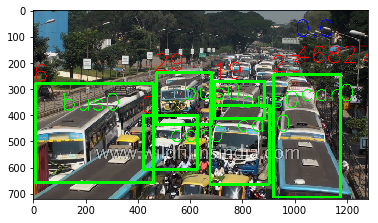

In [18]:
plt.imshow(final[300])
plt.show()

In [22]:
vwrite("originalvideo.mp4",orig_images)